# Klassifizierung mit neuronalen Netzen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

## Auswahl des Datensatzes

Es stehen zwei Datensätze zur Verfügung. 
* Wähle `dataset = 1` für einen linear separierbaren Datensatz.
* Wähle `dataset = 2` für einen nicht linear separierbaren Datensatz.
* Wähle `dataset = 3` für einen nicht linear separierbaren Datensatz mit unbalancierter Anzahl Daten pro Klasse.

In [55]:
# Auswählen des Datensatzes
dataset = 1
        
# Anzahl Datenpunkte pro Klasse 
num_samples_per_class = 200

# Für Reproduzierbarkeit
np.random.seed(42)


if dataset == 1:
    print('Datensatz 1')
    # Klasse 1 
    class_1 = np.random.randn(num_samples_per_class, 2) + np.array([2, 2])
    labels_class_1 = np.zeros((num_samples_per_class, 1))

    # Klasse 2
    class_2 = np.random.randn(num_samples_per_class, 2) + np.array([7, 7])
    labels_class_2 = np.ones((num_samples_per_class, 1))
    
    # Kombinieren der Daten
    data = np.vstack((class_1, class_2))
    labels = np.vstack((labels_class_1, labels_class_2)).flatten()   

elif dataset == 2:
    print('Datensatz 2')
    center = (0, 0)
    inner_radius, outer_radius = 4, 8

    # Klasse 1 
    theta = 2 * np.pi * np.random.rand(num_samples_per_class)
    r = inner_radius * np.random.rand(num_samples_per_class)
    x1 = center[0] + r * np.cos(theta)
    y1 = center[1] + r * np.sin(theta)
    class_1 = np.column_stack((x1, y1))  
    labels_class_1 = np.zeros(num_samples_per_class)  # Label von Klasse 2 = 0

    # Klasse 2 
    theta = 2 * np.pi * np.random.rand(num_samples_per_class)
    r = inner_radius + (outer_radius - inner_radius) * np.random.rand(num_samples_per_class)
    x2 = center[0] + r * np.cos(theta)
    y2 = center[1] + r * np.sin(theta)
    class_2 = np.column_stack((x2, y2))   
    labels_class_2 = np.ones(num_samples_per_class) # Label von Klasse 2  = 1
    
    # Kombinieren der Daten
    data = np.vstack((class_1, class_2))
    labels = np.hstack((labels_class_1, labels_class_2))   
    
else: 
    print('Datensatz 3')
    
    # Anzahl Datenpunkte pro Klasse 
    num_samples_class_1 = 800  # Viele  Daten von Klasse 1
    num_samples_class_2 = 200  # Wenige Daten von Klasse 2
    
    center = (0, 0)
    inner_radius, outer_radius = 2, 6  

    # Klasse 1  
    theta_1 = 2 * np.pi * np.random.rand(num_samples_class_1)
    r_1 = inner_radius + (outer_radius - inner_radius) * np.random.rand(num_samples_class_1)
    x1 = center[0] + r_1 * np.cos(theta_1)
    y1 = center[1] + r_1 * np.sin(theta_1)
    class_1 = np.column_stack((x1, y1))
    labels_class_1 = np.zeros(num_samples_class_1)   
    
    # Klasse 2  
    theta_2 = 2 * np.pi * np.random.rand(num_samples_class_2)
    r_2 = inner_radius + 3 + (outer_radius - inner_radius - 1) * np.random.rand(num_samples_class_2)
    x2 = center[0] + r_2 * np.cos(theta_2)
    y2 = center[1] + r_2 * np.sin(theta_2)
    class_2 = np.column_stack((x2, y2))
    labels_class_2 = np.ones(num_samples_class_2)  
    
    # Kombinieren der Daten
    data = np.vstack((class_1, class_2))
    labels = np.hstack((labels_class_1, labels_class_2))

    
# Daten in Trainings- und Testdaten unterteilen 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

Datensatz 1


## Visualisierung der Daten

Die Trainings- und Testdaten werden mit folgendem Code geplottet.

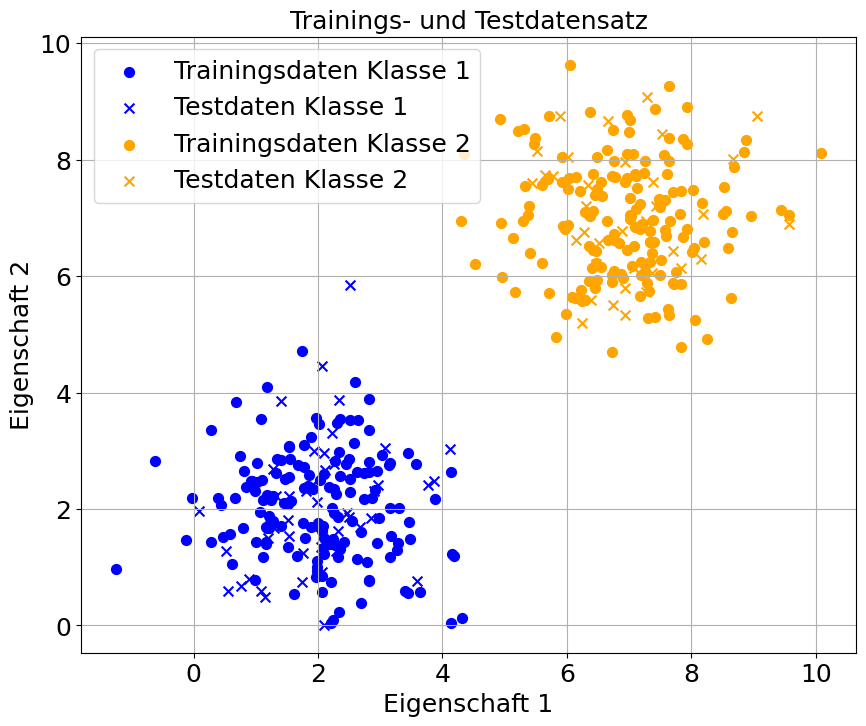

In [56]:
# Define colors
color_class_1 = 'blue'
color_class_2 = 'orange'

# Plot the data
plt.figure(figsize=(10, 8))

# Use the same color for training and test data of class 1
plt.scatter(X_train[y_train.flatten() == 0][:, 0], X_train[y_train.flatten() == 0][:, 1], s= 50, label='Trainingsdaten Klasse 1', color=color_class_1)
plt.scatter(X_test[y_test.flatten() == 0][:, 0], X_test[y_test.flatten() == 0][:, 1], color=color_class_1, marker='x', s= 50, label='Testdaten Klasse 1')

# Use the same color for training and test data of class 2
plt.scatter(X_train[y_train.flatten() == 1][:, 0], X_train[y_train.flatten() == 1][:, 1], s= 50, label='Trainingsdaten Klasse 2', color=color_class_2)
plt.scatter(X_test[y_test.flatten() == 1][:, 0], X_test[y_test.flatten() == 1][:, 1], s= 50, color=color_class_2, marker='x', label='Testdaten Klasse 2')

plt.title('Trainings- und Testdatensatz', fontsize=18)
plt.xlabel('Eigenschaft 1', fontsize=18)
plt.ylabel('Eigenschaft 2', fontsize=18)

# Skalenwerte auf Achsen vergrößern
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.grid(True)
plt.show()


## Trainieren eine Künstlichen Neuronalen Netzes 

Im Folgenden wird die Struktur des neuronalen Netzes festgelegt. 

* Füge weitere versteckte Schichten hinzu, indem du weitere Zeilen der Form `Dense(10, activation='sigmoid'),` ergänzt.
* Ändere die Anzahl Neuronen pro Schicht. 
* Ändere die Aktivierungsfunktionen, indem du `sigmoid` bspw. durch `linear` oder `ReLu` ersetzt.




In [57]:
# Festlegung der Struktur des neuronalen Netzes
model = Sequential([
    Dense(10, input_dim=2, activation='sigmoid'), # 1. versteckte Schicht mit 10 Neuronen und Sigmoid-Aktivierungsfunktion. Die Dimension der Eingangsdaten ist 2
    Dense(10, activation='sigmoid'), # 2. versteckte Schicht mit 10 Neuronen und Sigmoid-Aktivierungsfunktion
    Dense(1, activation='sigmoid') # Ausgabeschicht mit 1 Neuronen und Sigmoid-Aktivierungsfunktion
])

# Kompilieren des Modells
model.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError(), metrics=['accuracy']) # loss='binary_crossentropy'

### Training des Neuronalen Netzes

In [58]:
# Training des Modells 
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.0, verbose = 0)

# Auswertung auf den Testdaten 
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Genauigkeit auf den Testdaten: {test_accuracy:.2f}')

# Ausgabe der Genauigkeit auf den Trainingsdaten
final_train_accuracy = history.history['accuracy'][-1]
print(f'Genauigkeit auf den Trainingsdaten: {final_train_accuracy:.2f}')

3/3 [==============================] - 0s 890us/step - loss: 0.0017 - accuracy: 1.0000
Genauigkeit auf den Testdaten: 1.00
Genauigkeit auf den Trainingsdaten: 1.00


3/3 [==============================] - 0s 762us/step


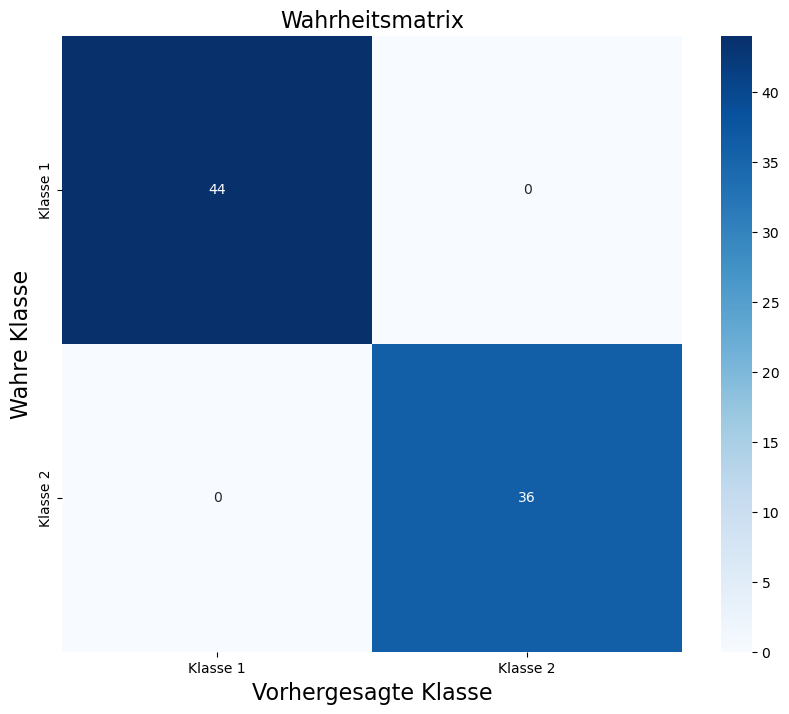

Genauigkeit: 1.0000
Präzision: 1.0000
Recall: 1.0000


In [59]:
# Vorhersagen auf den Testdaten
y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Verwirrungsmatrix erstellen
cm = confusion_matrix(y_test, y_test_pred)

# Verwirrungsmatrix anzeigen
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Klasse 1', 'Klasse 2'], yticklabels=['Klasse 1', 'Klasse 2']) 
plt.xlabel('Vorhergesagte Klasse', fontsize=16)
plt.ylabel('Wahre Klasse', fontsize=16)
plt.title('Wahrheitsmatrix', fontsize=16)
plt.show()

# Berechnung der Metriken
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

# Metriken ausgeben
print(f"Genauigkeit: {accuracy:.4f}") # Anteil der korrekten Vorhersagen an allen Vorhersagen aus.
print(f"Präzision: {precision:.4f}") # Anteil der als Kl. 1 (= positiv) vorhergesagten Beispiele tatsächlich Kl. 1 sind (True Positives / (True Positives + False Positives)).
print(f"Recall: {recall:.4f}") # Anteil der Daten von Kl. 1, die korrekt als als Kl. 1 vorhergesagt wurden (True Positives / (True Positives + False Negatives)).


### Visualisierung von Trainings- und Testdaten und  Entscheidungsgrenze

9665/9665 [==============================] - 2s 189us/step


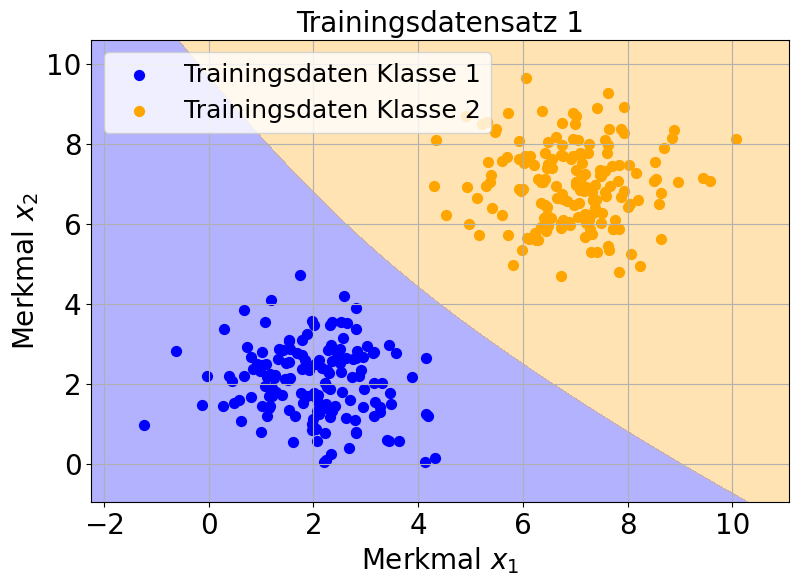

In [60]:
# Plotten der Daten 
plt.figure(figsize=(9, 6))

plt.scatter(X_train[y_train.flatten() == 0][:, 0], X_train[y_train.flatten() == 0][:, 1], s= 50, label='Trainingsdaten Klasse 1', color=color_class_1)
#plt.scatter(X_test[y_test.flatten() == 0][:, 0], X_test[y_test.flatten() == 0][:, 1], color=color_class_1, marker='x', s= 50, label='Testdaten Klasse 1')
plt.scatter(X_train[y_train.flatten() == 1][:, 0], X_train[y_train.flatten() == 1][:, 1], s= 50, label='Trainingsdaten Klasse 2', color=color_class_2)
#plt.scatter(X_test[y_test.flatten() == 1][:, 0], X_test[y_test.flatten() == 1][:, 1], s= 50, color=color_class_2, marker='x', label='Testdaten Klasse 2')

# Plotten der Entscheidungsgrenze
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.05))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = model.predict(grid).reshape(xx.shape)
plt.contourf(xx, yy, grid_predictions, alpha=0.3, levels=[0, 0.5, 1], colors=['blue', 'orange'])

plt.title('Trainingsdatensatz', fontsize = 20) 
plt.xlabel(r'Merkmal $x_1$', fontsize=20)
plt.ylabel(r'Merkmal $x_2$', fontsize =20)  
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18,  loc='upper left')
plt.grid(True)

plt.savefig('nonlinsepdata_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

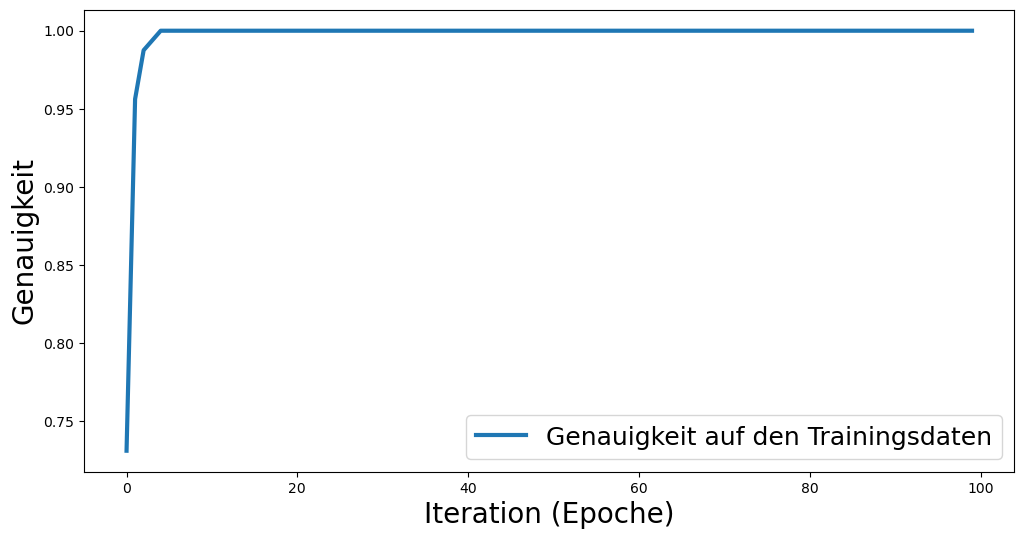

In [39]:
# Plotten der prozentualen Genauigkeit (engl. accuracy) auf den Trainingsdaten 
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], linewidth= 3, label='Genauigkeit auf den Trainingsdaten') 
plt.xlabel('Iteration (Epoche)', fontsize = 20)  
plt.ylabel('Genauigkeit', fontsize = 20)  
plt.legend(fontsize=18)
plt.show()